# Credit Risk Prediction App


* Sandikha Rahardi (Kuldii Project)
* https://kuldiiproject.com


This notebook builds an interactive credit risk prediction app using the Statlog (German Credit Data) dataset from the UCI Machine Learning Repository. The workflow includes:
- Data loading and EDA
- Preprocessing
- Training multiple classification models
- Model evaluation
- An interactive Gradio interface for predictions

---

## 1. Import required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import gradio as gr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 2. Load the Statlog (German Credit Data) Dataset

We use the `ucimlrepo` package to fetch the Statlog (German Credit Data) dataset directly from the UCI Machine Learning Repository.

You can check the dataset details at this link: [https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)

In [2]:
# Load the Statlog (German Credit Data) dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# Use recommended ucimlrepo API
X = statlog_german_credit_data.data.features.copy()
y = statlog_german_credit_data.data.targets.iloc[:, 0].copy()  # y is a DataFrame, get the first column

# Use variable info for user-friendly names
variables = statlog_german_credit_data.variables
feature_names = X.columns.tolist()

# Convert variables DataFrame to a dictionary for easy lookup
variables_dict = variables.set_index('name').to_dict('index')

# Build a mapping from original column to readable name
feature_labels = {col: variables_dict[col]['description'] if 'description' in variables_dict[col] and variables_dict[col]['description'] else col for col in feature_names}

# Rename columns for user-facing EDA and Gradio UI
X_display = X.rename(columns=feature_labels)

X_display

,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


## 3. Exploratory Data Analysis (EDA)

Let's explore the dataset: check its structure, summary statistics, class distribution, and visualize key features.

In [3]:
X_display.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       1000 non-null   object
 1   Duration                                                  1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account/bonds                                     1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   Personal status and sex      

In [4]:
X_display.describe()

,Duration,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [5]:
# Class distribution
print("\nClass distribution:")
class_counts = y.value_counts().sort_index()
class_labels = [str(c) for c in class_counts.index]
print(class_counts)
print("\nClass description:")
print("1 = Good credit risk (creditworthy)")
print("2 = Bad credit risk (not creditworthy)")


Class distribution:
class
1    700
2    300
Name: count, dtype: int64

Class description:
1 = Good credit risk (creditworthy)
2 = Bad credit risk (not creditworthy)


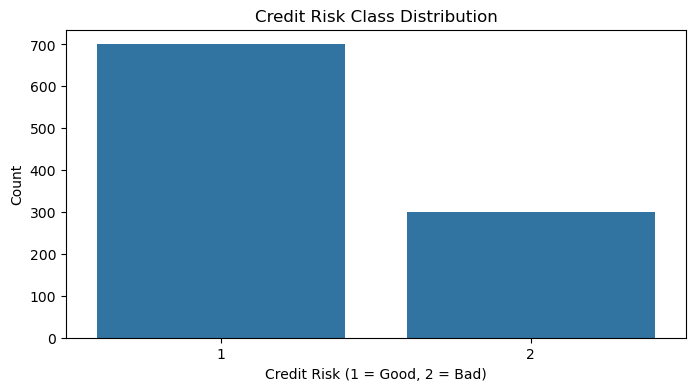

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(x=y.map(dict(zip(y.unique(), [str(c) for c in y.unique()]))))
plt.title('Credit Risk Class Distribution')
plt.xlabel('Credit Risk (1 = Good, 2 = Bad)')
plt.ylabel('Count')
plt.show()

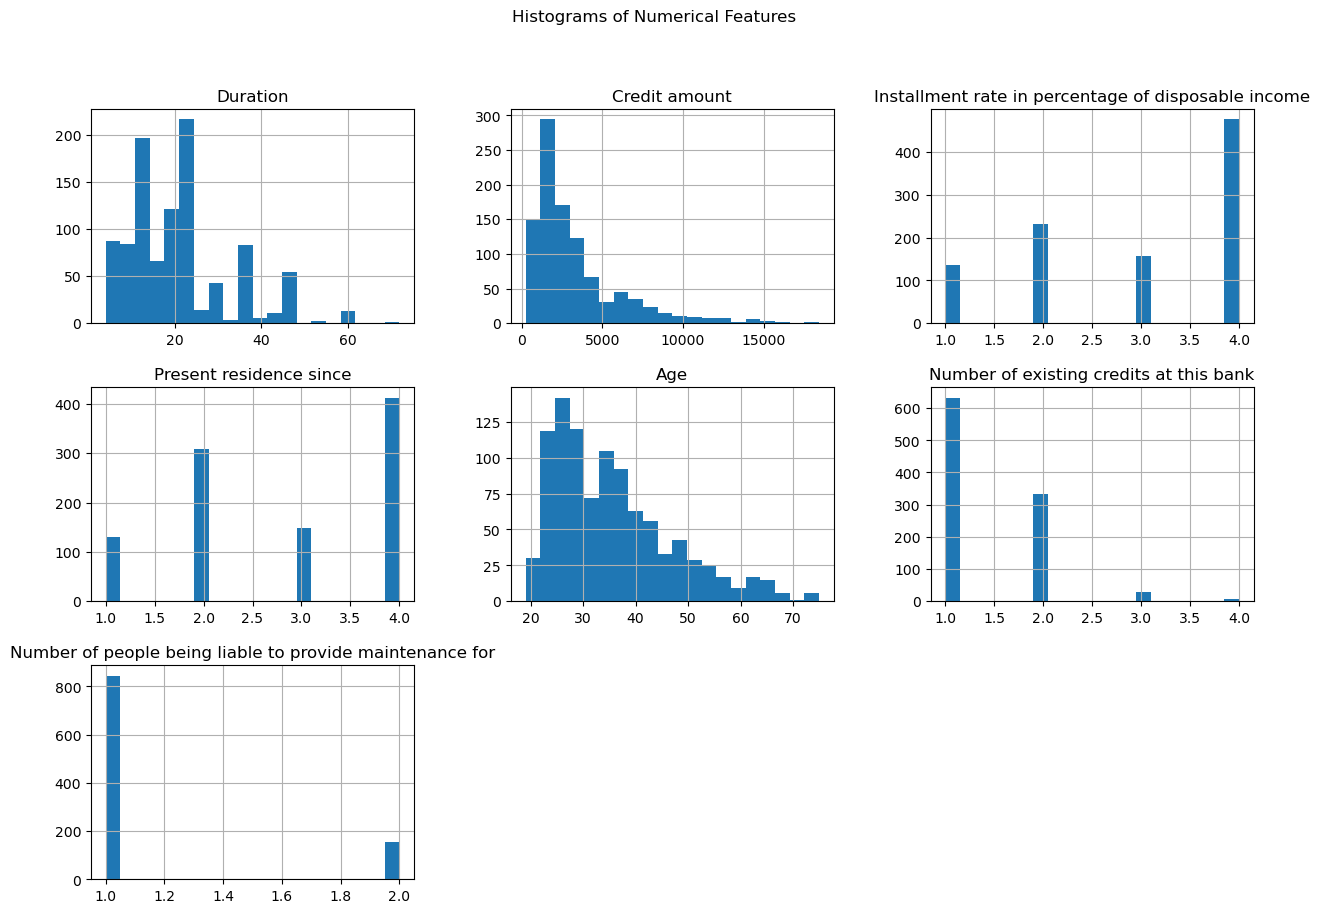

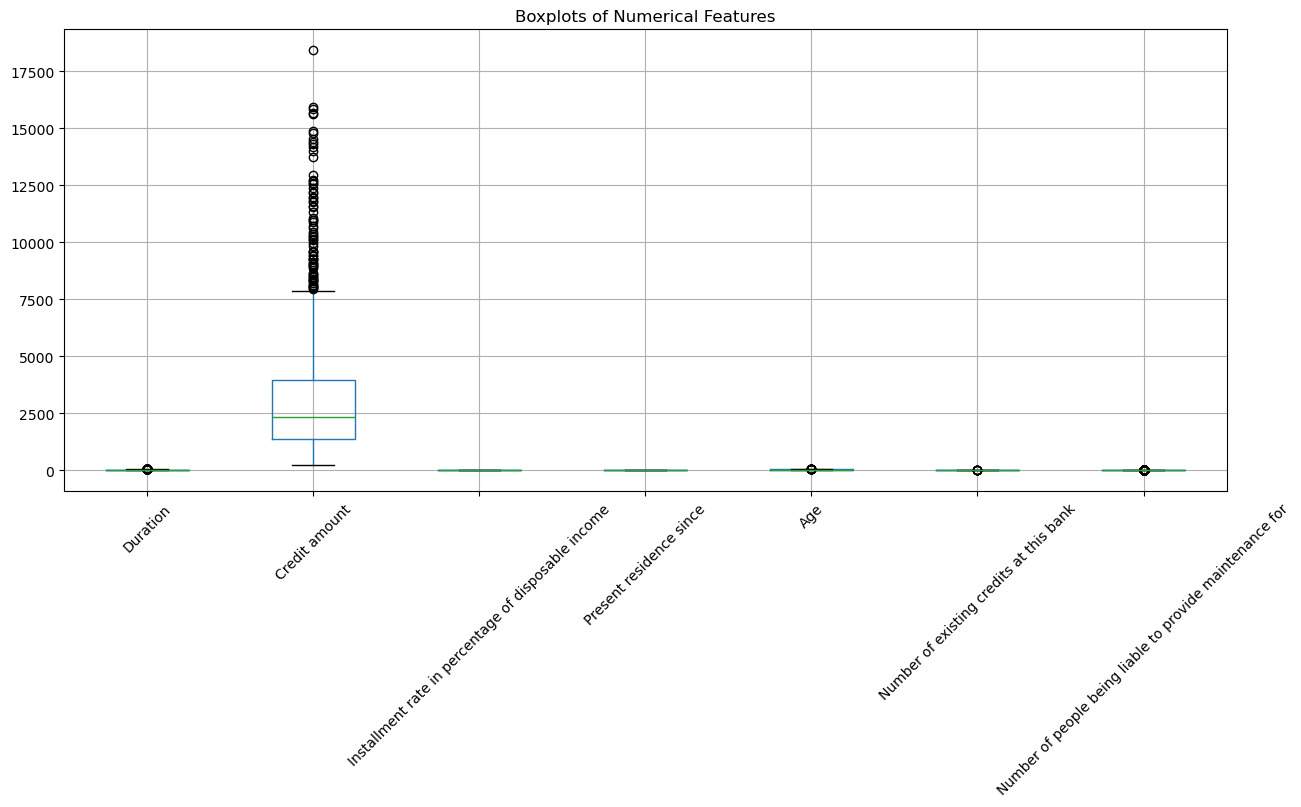

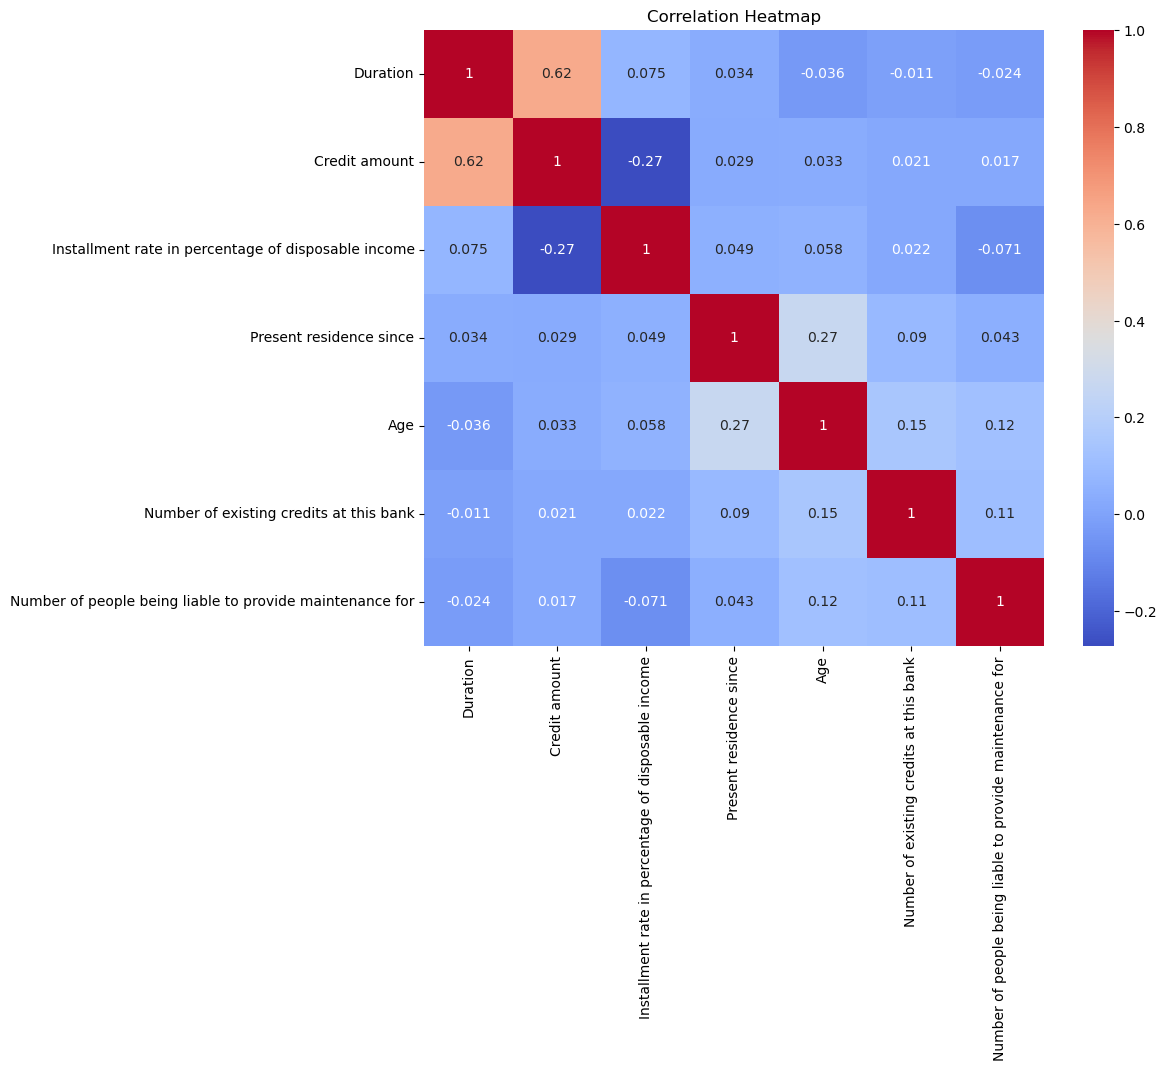

In [7]:
# Visualize numerical features
num_cols = X_display.select_dtypes(include=[np.number]).columns.tolist()
X_display[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Boxplots
plt.figure(figsize=(15, 6))
X_display[num_cols].boxplot()
plt.title('Boxplots of Numerical Features')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_display[num_cols].corr(), annot=True, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Correlation Heatmap')
plt.show()

## 4. Data Preprocessing

We will handle missing values, encode categorical features, and scale numerical features to prepare the data for modeling.

In [8]:
# Preprocessing
# 1. Handle missing values (if any)
print('Missing values per column:')
print(X_display.isnull().sum())

# 2. Encode categorical features
cat_cols = X_display.select_dtypes(include=['object']).columns.tolist()
if 'class' in cat_cols:
    cat_cols.remove('class')  # Exclude target

# Only encode if there are categorical columns
le_dict = {}
X_encoded = X_display.copy()
if cat_cols:
    for col in cat_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
        le_dict[col] = le

# 3. Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 4. Scale numerical features
num_cols = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
if 'class' in num_cols:
    num_cols.remove('class')
if num_cols:
    scaler = StandardScaler()
    X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# Ensure feature_names and feature_labels are always from variables_dict
# (already handled in previous cell)

X_encoded

Missing values per column:
Status of existing checking account                         0
Duration                                                    0
Credit history                                              0
Purpose                                                     0
Credit amount                                               0
Savings account/bonds                                       0
Present employment since                                    0
Installment rate in percentage of disposable income         0
Personal status and sex                                     0
Other debtors / guarantors                                  0
Present residence since                                     0
Property                                                    0
Age                                                         0
Other installment plans                                     0
Housing                                                     0
Number of existing credits at this bank    

,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker
0,-1.254566,-1.236478,1.344014,0.264068,-0.745131,1.833169,1.338078,0.918477,0.449326,-0.303686,1.046987,-1.293723,2.766456,0.460831,0.133710,1.027079,0.146949,-0.428290,1.214598,-0.196014
1,-0.459026,2.248194,-0.503428,0.264068,0.949817,-0.699707,-0.317959,-0.870183,-0.963650,-0.303686,-0.765977,-1.293723,-1.191404,0.460831,0.133710,-0.704926,0.146949,-0.428290,-0.823318,-0.196014
2,1.132053,-0.738668,1.344014,1.359785,-0.416562,-0.699707,0.510060,-0.870183,0.449326,-0.303686,0.140505,-1.293723,1.183312,0.460831,0.133710,-0.704926,-1.383771,2.334869,-0.823318,-0.196014
3,-1.254566,1.750384,-0.503428,-0.101171,1.634247,-0.699707,0.510060,-0.870183,0.449326,3.885083,1.046987,-0.341055,0.831502,0.460831,2.016956,-0.704926,0.146949,2.334869,-0.823318,-0.196014
4,-1.254566,0.256953,0.420293,-1.196889,0.566664,-0.699707,-0.317959,0.024147,0.449326,-0.303686,1.046987,1.564281,1.535122,0.460831,2.016956,1.027079,0.146949,2.334869,-0.823318,-0.196014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.132053,-0.738668,-0.503428,-0.101171,-0.544162,-0.699707,0.510060,0.024147,-0.963650,-0.303686,1.046987,-1.293723,-0.399832,0.460831,0.133710,-0.704926,-1.383771,-0.428290,-0.823318,-0.196014
996,-1.254566,0.754763,-0.503428,-0.831650,0.207612,-0.699707,-0.317959,0.918477,-2.376626,-0.303686,1.046987,-0.341055,0.391740,0.460831,0.133710,-0.704926,1.677670,-0.428290,1.214598,-0.196014
997,1.132053,-0.738668,-0.503428,0.264068,-0.874503,-0.699707,1.338078,0.918477,0.449326,-0.303686,1.046987,0.611613,0.215835,0.460831,0.133710,-0.704926,0.146949,-0.428290,-0.823318,-0.196014
998,-1.254566,1.999289,-0.503428,0.264068,-0.505528,-0.699707,-0.317959,0.918477,0.449326,-0.303686,1.046987,1.564281,-1.103451,0.460831,2.016956,-0.704926,0.146949,-0.428290,1.214598,-0.196014


## 5. Split the Dataset into Train and Test Sets

We split the preprocessed data into training and testing sets for model evaluation.

In [9]:
# Split features and target
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (800, 20), Test shape: (200, 20)


## 6. Train Classification Models

We will train three models: Logistic Regression, Random Forest, and XGBoost Classifier.

In [10]:
# Train models with hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

models = {}

# Logistic Regression
lr_params = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)
models['Logistic Regression'] = lr_grid.best_estimator_
print(f"Best Logistic Regression params: {lr_grid.best_params_}")

# Random Forest
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
models['Random Forest'] = rf_grid.best_estimator_
print(f"Best Random Forest params: {rf_grid.best_params_}")

# XGBoost
xgb_params = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
models['XGBoost'] = xgb_grid.best_estimator_
print(f"Best XGBoost params: {xgb_grid.best_params_}")

print("\n\nModels trained with best parameters: ", list(models.keys()))

Best Logistic Regression params: {'C': 10, 'solver': 'liblinear'}
Best Random Forest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


Models trained with best parameters:  ['Logistic Regression', 'Random Forest', 'XGBoost']


## 7. Evaluate Model Performance

We will evaluate each model using accuracy, classification report, and confusion matrix. Visualizations will help compare model performances.


Logistic Regression Accuracy: 0.7650
              precision    recall  f1-score   support

           1       0.81      0.86      0.84       140
           2       0.63      0.53      0.58        60

    accuracy                           0.77       200
   macro avg       0.72      0.70      0.71       200
weighted avg       0.76      0.77      0.76       200



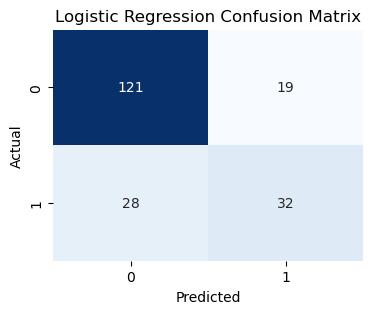


Random Forest Accuracy: 0.7650
              precision    recall  f1-score   support

           1       0.78      0.92      0.85       140
           2       0.69      0.40      0.51        60

    accuracy                           0.77       200
   macro avg       0.73      0.66      0.68       200
weighted avg       0.75      0.77      0.74       200



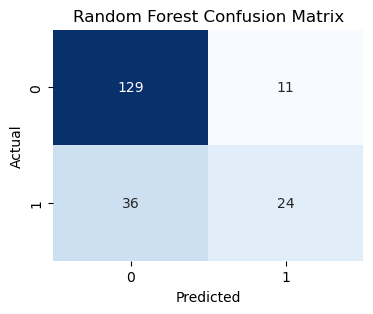


XGBoost Accuracy: 0.7700
              precision    recall  f1-score   support

           1       0.80      0.89      0.84       140
           2       0.66      0.48      0.56        60

    accuracy                           0.77       200
   macro avg       0.73      0.69      0.70       200
weighted avg       0.76      0.77      0.76       200



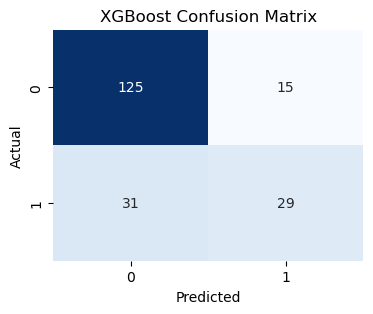

In [11]:
# Evaluate models
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[str(c) for c in le_target.classes_])
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {'accuracy': acc, 'report': report, 'cm': cm}
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(report)
    plot_conf_matrix(cm, f'{name} Confusion Matrix')

## 8. Build and Customize Gradio Interface

We will create an interactive Gradio app for credit risk prediction. Users can input feature values, select a model, and view predictions, probabilities, and feature importances.

The Gradio interface will:
- Allow model selection (Logistic Regression, Random Forest, XGBoost)
- Dynamically generate input fields for all features (dropdowns for categoricals, sliders/numbers for numerics)
- Display the prediction and class probabilities in a styled output box
- Use a visually appealing layout with grouped inputs (3 per row) and clear labels
- Provide a markdown header and dataset link for user context

In [12]:
# # Save all trained models and preprocessing objects for deployment
# import joblib
# import os

# os.makedirs('models', exist_ok=True)
# # Save models
# joblib.dump(models, 'models/models.pkl')
# # Save encoders, scaler, and feature info
# joblib.dump({
#     'le_dict': le_dict,
#     'scaler': scaler,
#     'le_target': le_target,
#     'feature_names': feature_names,
#     'feature_labels': feature_labels, 
#     'cat_cols': cat_cols,
#     'num_cols': num_cols
# }, 'models/preprocessing.pkl')

# # Save feature statistics (min, max, mean) for each numeric/integer feature
# feature_stats = {}
# for col in feature_names:
#     if col in cat_cols:
#         continue
#     # Pastikan kolom ada di X_display
#     if col not in X_display.columns:
#         continue
#     # Paksa konversi ke float, handle error
#     col_data = pd.to_numeric(X_display[col], errors='coerce')
#     min_val = col_data.min()
#     max_val = col_data.max()
#     mean_val = col_data.mean()
#     # Ganti NaN dengan 0
#     if pd.isna(min_val):
#         min_val = 0.0
#     if pd.isna(max_val):
#         max_val = 0.0
#     if pd.isna(mean_val):
#         mean_val = 0.0
#     feature_stats[col] = {
#         'min': float(min_val),
#         'max': float(max_val),
#         'mean': float(mean_val)
#     }
# joblib.dump(feature_stats, 'models/feature_stats.pkl')
# print('Models, preprocessing objects, and feature_stats saved to models/ directory.')


In [13]:
import joblib

# Save feature statistics (min, max, mean) for each numeric/integer feature
feature_stats = {}
for col in feature_names:
    if col in cat_cols:
        continue
    # Pastikan kolom ada di X_display
    if col not in X_display.columns:
        continue
    # Paksa konversi ke float, handle error
    col_data = pd.to_numeric(X_display[col], errors='coerce')
    min_val = col_data.min()
    max_val = col_data.max()
    mean_val = col_data.mean()
    # Ganti NaN dengan 0
    if pd.isna(min_val):
        min_val = 0.0
    if pd.isna(max_val):
        max_val = 0.0
    if pd.isna(mean_val):
        mean_val = 0.0
    feature_stats[col] = {
        'min': float(min_val),
        'max': float(max_val),
        'mean': float(mean_val)
    }

integer_features = [feature_labels.get(c, c) for c in [
        'Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']]

# Buat dictionary berisi SEMUA komponen
model_bundle = {
    "models": models,
    "le_dict": le_dict,
    "le_target": le_target,
    "scaler": scaler,
    "feature_labels": feature_labels,
    "feature_stats": feature_stats,
    "cat_cols": cat_cols,
    "num_cols": num_cols,
    "integer_features": integer_features
}

joblib.dump(model_bundle, "models/model_bundle.pkl")
print("Model bundle saved!")


Model bundle saved!


In [14]:
# Prediction function
def predict_credit_risk_blocks(selected_model, *feature_values):
    input_dict = {}
    integer_features = [feature_labels.get(c, c) for c in [
        'Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']]
    for i, col in enumerate(feature_labels.values()):
        val = feature_values[i]
        if col in integer_features:
            val = int(round(val)) if val is not None else int(round(feature_stats.get(col, {}).get('mean', 0)))
        elif col in cat_cols:
            if val not in le_dict[col].classes_:
                val = le_dict[col].classes_[0]
        else:
            val = float(val) if val is not None else float(feature_stats.get(col, {}).get('mean', 0))
        input_dict[col] = val
    input_df = pd.DataFrame([input_dict])
    for col in cat_cols:
        le = le_dict[col]
        input_df[col] = le.transform([input_df[col][0]])
    if num_cols:
        input_df[num_cols] = scaler.transform(input_df[num_cols])
    model = models[selected_model]
    pred = model.predict(input_df)[0]
    proba = model.predict_proba(input_df)[0]
    pred_label_num = le_target.inverse_transform([pred])[0]
    label_map = {'1': 'Good', '2': 'Bad'}
    pred_label = label_map.get(str(pred_label_num), str(pred_label_num))
    proba_str = "\n".join([
        f"{label_map.get(str(le_target.inverse_transform([i])[0]), str(le_target.inverse_transform([i])[0]))}: {p:.2%}"
        for i, p in enumerate(proba)
    ])
    return f"\U0001F4B3 Predicted Credit Risk: {pred_label}\n\nProbabilities:\n{proba_str}\n\n(Model: {selected_model})"

# Build Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("""
    <h2>🏦 Credit Risk Prediction</h2>
    <p style=\"font-size: 16px;\">
    Built with Scikit-learn, XGBoost & Gradio — by Kuldii Project
    </p>
    <p style=\"font-size: 14px;\">
    This app predicts the credit risk (good/bad) for a loan applicant based on various financial and personal attributes.<br>
    ✅ Select a model<br>
    📝 Enter applicant details<br>
    🔮 Get the prediction and class probabilities<br>
    📂 <strong>Dataset:</strong> <a href=\"https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data\" target=\"_blank\">
    Statlog (German Credit Data)</a> from UCI Machine Learning Repository.
    </p>
    """)
    model_choice = gr.Dropdown(
        choices=list(models.keys()),
        label="✨ Select Classification Model",
        value=list(models.keys())[0]
    )
    integer_features = [feature_labels.get(c) for c in [
        'Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']]
    input_elems = []
    cols = list(feature_labels.values())
    for idx in range(0, len(cols), 3):
        with gr.Row():
            for j in range(3):
                if idx + j >= len(cols):
                    break
                col = cols[idx + j]
                label = col
                if col in cat_cols:
                    comp = gr.Dropdown(
                        choices=le_dict[col].classes_.tolist(),
                        label=f"🔘 {label}",
                        value=le_dict[col].classes_[0]
                    )
                elif col in integer_features:
                    stats = feature_stats.get(col, {'min': 0, 'max': 10, 'mean': 5})
                    min_val = int(stats['min'])
                    max_val = int(stats['max'])
                    mean_val = int(round(stats['mean']))
                    comp = gr.Number(
                        label=f"🔢 {label}",
                        value=mean_val,
                        minimum=min_val,
                        maximum=max_val,
                        step=1
                    )
                else:
                    stats = feature_stats.get(col, {'min': 0.0, 'max': 10.0, 'mean': 5.0})
                    min_val = float(stats['min'])
                    max_val = float(stats['max'])
                    mean_val = float(stats['mean'])
                    comp = gr.Slider(
                        minimum=min_val,
                        maximum=max_val,
                        value=mean_val,
                        label=f"📊 {label}"
                    )
                input_elems.append(comp)
    predict_btn = gr.Button("🚀 Predict Credit Risk")
    output = gr.Textbox(label="🔎 Prediction Result", lines=5)
    predict_btn.click(
        fn=predict_credit_risk_blocks,
        inputs=[model_choice] + input_elems,
        outputs=output
    )
demo.launch(share=False)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
